# Effect of normalization in the segmentation-based approach

This notebook explores the effect of normalizing the data. This is done by once training the model on unnormalized data, and once on normalized data (between 0 and 1).

In [10]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


**Data Preperation**

Bring the data to a right form, with a function that does it in a unnormalized and normalized way.

In [5]:
images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))
    
nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

images_high_mask = (images_noisy_sum>60)    
    
threshold = 0
data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

In [6]:
# Function that splits the data to training and testing set, and does or does not do that in a normalization way
# The variable 'normalize' should be passed as a boolean here.
def data_norm(data_noisy, data_true, normalize):
    images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
    images_true_sum = np.nansum(data_true, axis=(1,2))
    
    nan_mask = np.isnan(data_noisy[0])
    data_noisy_nonan = np.nan_to_num(data_noisy)
    data_true_nonan = np.nan_to_num(data_true)

    images_high_mask = (images_noisy_sum>60)    
    
    threshold = 0
    data_true_binary = np.zeros((64*chunk_tot, 56, 56))
    data_true_binary[data_true>threshold] = 1
    data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
    
    # Putting them to the right form with normalization
    data_noisy_arr = data_noisy[images_high_mask]
    
    # Do it differently depending on normalization or not
    if normalize == False:
        data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
    elif normalize == True:
        data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0
        pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
        data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max)

        data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
    
    
    data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

    data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
    data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()
    
    # Split train and test

    N, w, h = data_noisy_tensor.shape
    idx_split = int(N*0.8) # 80% training, 20% testing
    
    # Split all the noisy and true data to their test and training forms
    data_noisy_train = data_noisy_tensor[:idx_split]
    data_true_train = data_true_tensor[:idx_split]
    data_noisy_test = data_noisy_tensor[idx_split:]
    data_true_test = data_true_tensor[idx_split:]

    data_noisy_train_im = data_noisy_tensor_im[:idx_split]
    data_true_train_im = data_true_tensor_im[:idx_split]
    data_noisy_test_im = data_noisy_tensor_im[idx_split:]
    data_true_test_im = data_true_tensor_im[idx_split:]
    
    return data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split

In [7]:
# Test it once
data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_norm(data_noisy, data_true, True)



**Fitting Functions**

In [8]:
# AE with 4 convolutional layers and 4 deconvolutional layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [34]:
# Functions and definitions for 
n_epochs = 15

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

batch_size=1

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            #IOU += IOU_calc(output_binary, true)
            IOU += jaccard_score(output_binary[0], true[0])
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [35]:
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [36]:
test_losses_all = []
IOU_all = []

**Without normalization**

In [37]:
%%time

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

learning_rate = 0.001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_norm(data_noisy, data_true, False)
    
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.6788
IOU: 0.052730327378526815
Training set: Avg. loss: 0.1422

Test set: Avg. loss: 0.0892
IOU: 0.385652133584526
Training set: Avg. loss: 0.1023

Test set: Avg. loss: 0.0791
IOU: 0.4424795765884035
Training set: Avg. loss: 0.0942

Test set: Avg. loss: 0.0757
IOU: 0.47054113754901206
Training set: Avg. loss: 0.0894

Test set: Avg. loss: 0.0752
IOU: 0.4712545058529706
Training set: Avg. loss: 0.0883

Test set: Avg. loss: 0.0726
IOU: 0.4788576835099554
Training set: Avg. loss: 0.0843

Test set: Avg. loss: 0.0773
IOU: 0.47367768820118034
Training set: Avg. loss: 0.0874

Test set: Avg. loss: 0.0834
IOU: 0.46434315526212405
Training set: Avg. loss: 0.0839

Test set: Avg. loss: 0.0717
IOU: 0.4818135516432824
Training set: Avg. loss: 0.0822

Test set: Avg. loss: 0.0712
IOU: 0.48792396328176885
Training set: Avg. loss: 0.0824

Test set: Avg. loss: 0.0722
IOU: 0.48842352358453645
Training set: Avg. loss: 0.0813

Test set: Avg. loss: 0.0718
IOU: 0.48867650233115884
Train

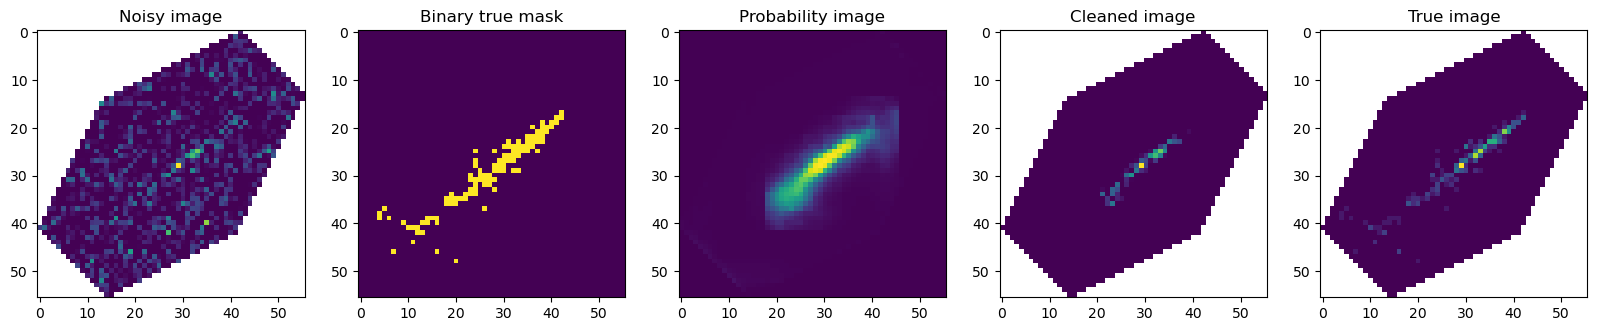

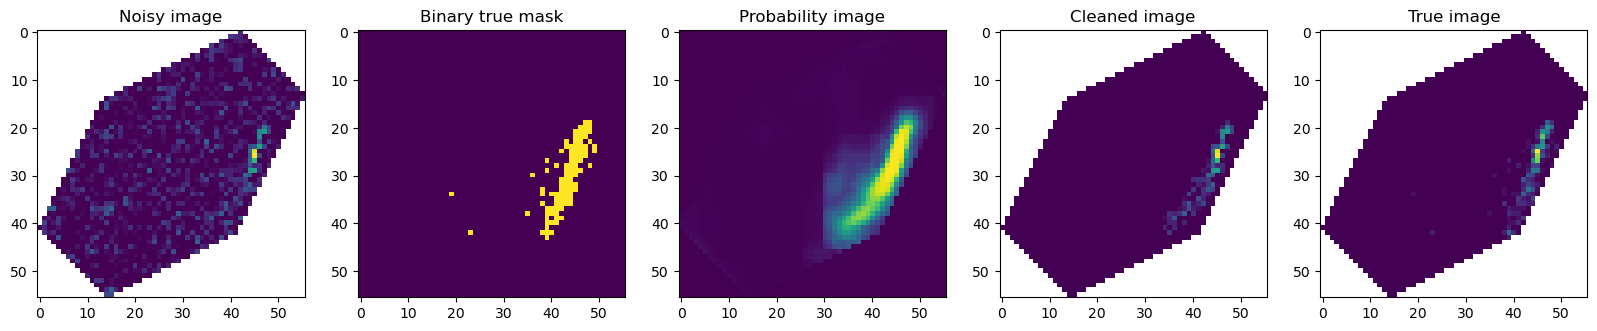

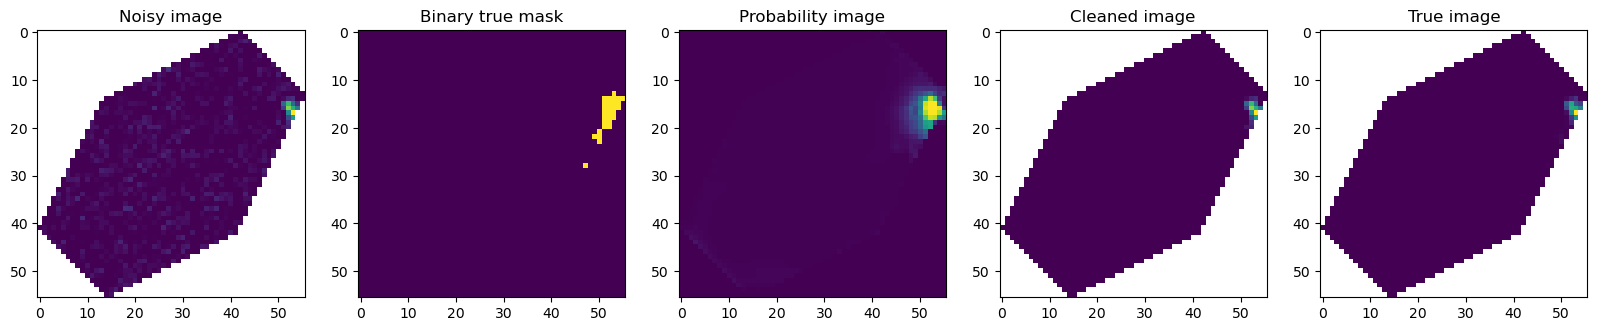

In [38]:
n_start = 10
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**With normalization**

In [39]:
%%time

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

learning_rate = 0.001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_noisy_train_im, data_true_train_im, data_noisy_test_im, data_true_test_im, data_true_binary, idx_split = data_norm(data_noisy, data_true, True)
    
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
test_losses_all.append(test_losses)
IOU_all.append(IOU_list)


Test set: Avg. loss: 0.6573
IOU: 0.00055346014452605
Training set: Avg. loss: 0.1587

Test set: Avg. loss: 0.0992
IOU: 0.4047594480220828
Training set: Avg. loss: 0.1187

Test set: Avg. loss: 0.0855
IOU: 0.43398226727372374
Training set: Avg. loss: 0.1059

Test set: Avg. loss: 0.0823
IOU: 0.4514625360545883
Training set: Avg. loss: 0.0979

Test set: Avg. loss: 0.0783
IOU: 0.459612917152392
Training set: Avg. loss: 0.0964

Test set: Avg. loss: 0.0966
IOU: 0.42277487060481117
Training set: Avg. loss: 0.0937

Test set: Avg. loss: 0.0769
IOU: 0.46000925484759747
Training set: Avg. loss: 0.0917

Test set: Avg. loss: 0.0811
IOU: 0.45961952491372576
Training set: Avg. loss: 0.0901

Test set: Avg. loss: 0.0763
IOU: 0.4703857637754623
Training set: Avg. loss: 0.0899

Test set: Avg. loss: 0.0752
IOU: 0.47146540114149105
Training set: Avg. loss: 0.0881

Test set: Avg. loss: 0.0748
IOU: 0.47594037549069135
Training set: Avg. loss: 0.0870

Test set: Avg. loss: 0.0768
IOU: 0.4683912765870114
Traini

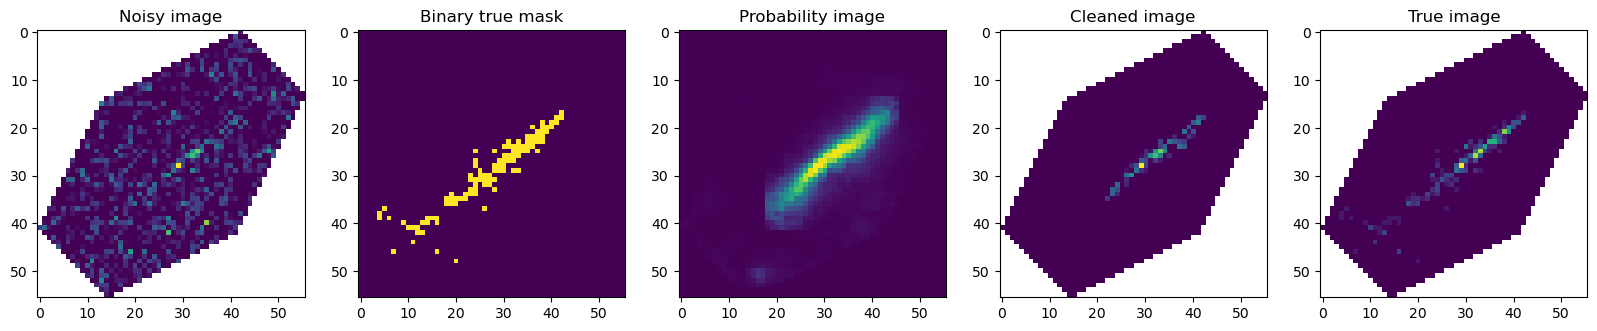

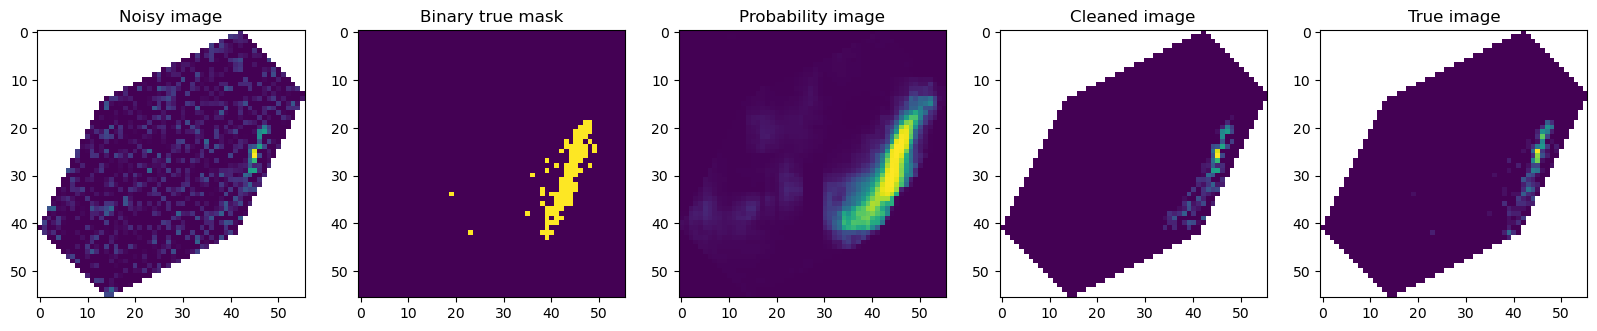

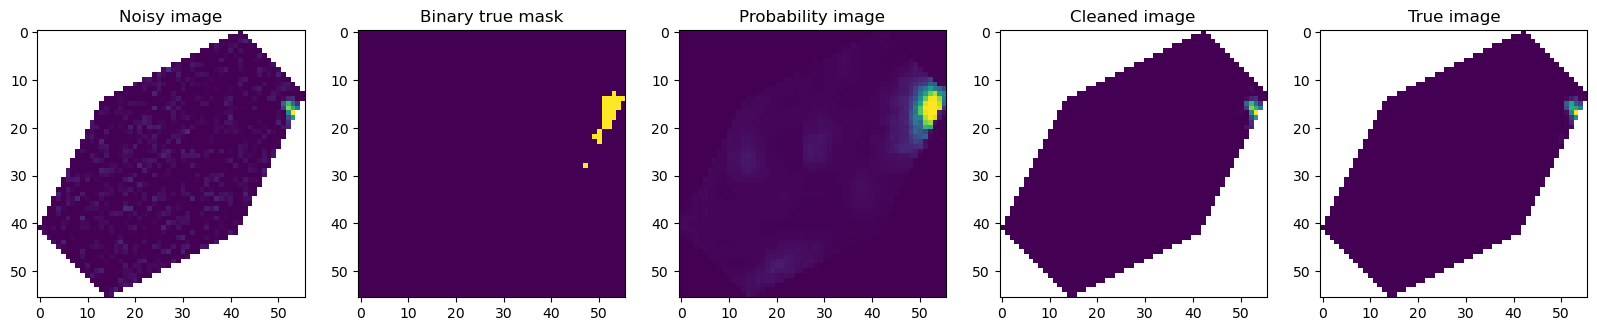

In [40]:
n_start = 10
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

**Comparing with each other**

In [41]:
test_losses_arr = np.array(test_losses_all)
IOU_all_arr = np.array(IOU_all)

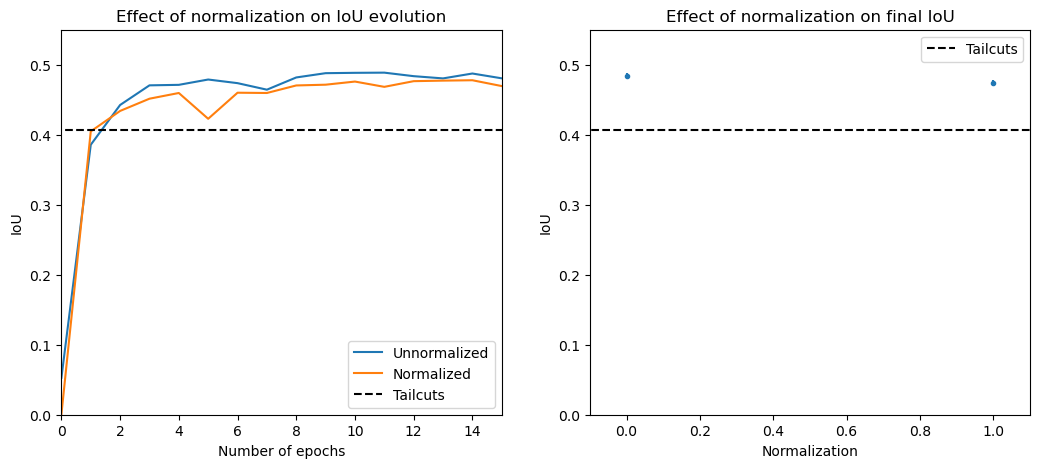

In [46]:
# Plot the fitting results as the loss function and the IoU

fig_norm2, axs = plt.subplots(1, 2, figsize=(12.5,5))

axs[0].set_title("Effect of normalization on IoU evolution")
axs[0].plot(test_counter, IOU_all_arr[0], label='Unnormalized')
axs[0].plot(test_counter, IOU_all_arr[1], label='Normalized')
axs[0].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[0].set_xlim(0,n_epochs)
axs[0].set_ylim(0,0.55)
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("IoU")
axs[0].legend()

axs[1].set_title("Effect of normalization on final IoU")
axs[1].errorbar(np.array([0,1]), np.mean(IOU_all_arr[:, -5:], axis=1), yerr=np.std(IOU_all_arr[:, -5:], axis=1), fmt='.')
axs[1].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[1].set_xlabel("Normalization")
axs[1].set_ylabel("IoU")
axs[1].legend()
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(0,0.55)

plt.show()
fig_norm2.savefig("images/Segmentation_norm2.pdf")

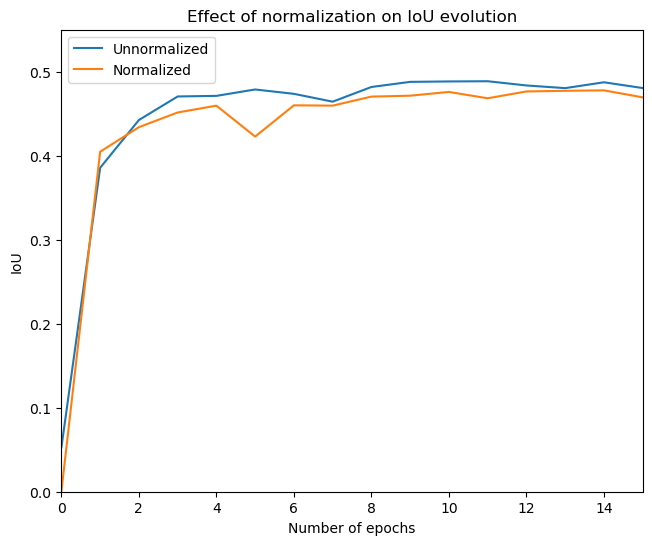

In [47]:
# Plot the fitting results as the loss function and the IoU

#fig, axs = plt.subplots(1, 2, figsize=(12.5,5))

fig_norm = plt.figure(figsize=(7.5,6))

plt.title("Effect of normalization on IoU evolution")
plt.plot(test_counter, IOU_all_arr[0], label='Unnormalized')
plt.plot(test_counter, IOU_all_arr[1], label='Normalized')
plt.xlim(0,n_epochs)
plt.ylim(0,0.55)
plt.xlabel("Number of epochs")
plt.ylabel("IoU")
plt.legend()

plt.show()
fig_norm.savefig("images/Segmentation_norm.pdf")